In [1]:
import glob
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Polygon

plt.style.use("ggplot")

# Accumulated EMEP deposition

Processing of EMEP depositon data for Heleen's 1000 Lakes manuscript. See e-mails received 25.01.2022 at 09.14 and 09.02.2022 at 11.20 for details.

Heleen would like accumulated values calculating from various points in the past to the "present" year (2020)

In [2]:
# Start year for periods of interest (all until 2020)
periods = [1880, 1900, 1950, 1970, 1980, 1990, 2000]

## 1. Regions of interest

Heleen is interested in the "forsuringsregionene", which were previously used for the 1000 Lakes report. She has also further grouped these regions into 6 broader areas, which are defined below.

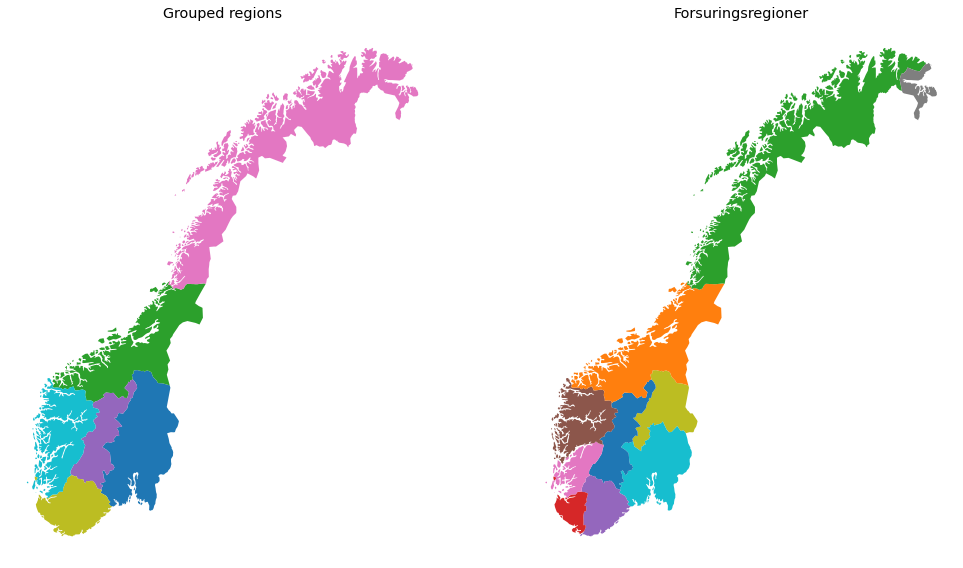

In [3]:
def assign_area_groupings(row):
    """Assign region groupings defined by Heleen.
    See e-mail received 09.02.2022 at 11.20.
    """
    if row["REGION"] in (1, 2):
        return "East"
    elif row["REGION"] == 8:
        return "Middle"
    elif row["REGION"] == 3:
        return "Mountains"
    elif row["REGION"] in (9, 10):
        return "North"
    elif row["REGION"] in (4, 5):
        return "South"
    elif row["REGION"] in (6, 7):
        return "West"
    else:
        raise ValueError("Can't assign region")


# Read shapefile
regs_for = "~/projects/1000_lakes/1000_lakes_2019/data/forsuringsregionene.shp"
for_gdf = gpd.read_file(regs_for)
for_gdf["agg_name"] = for_gdf.apply(assign_area_groupings, axis=1)
agg_gdf = for_gdf.dissolve(by="agg_name").reset_index()
del agg_gdf["name"]
agg_gdf.rename({"agg_name": "name"}, inplace=True, axis="columns")

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
agg_gdf.plot(ax=axes[0], column="name")
for_gdf.plot(ax=axes[1], column="name")
axes[0].set_title("Grouped regions")
axes[1].set_title("Forsuringsregioner")
axes[0].set_axis_off()
axes[1].set_axis_off()
plt.tight_layout()

## 2. Build grid for deposition data

The data are described [here](https://github.com/JamesSample/critical_loads_2/issues/4).

In [4]:
# Get a list of files to process. Only need "grid averages"
data_fold = r"../data"
search_path = os.path.join(data_fold, "*_a.NO")
flist = glob.glob(search_path)
flist

['../data/N_LoLa_a.NO', '../data/A_LoLa_a.NO', '../data/S_LoLa_a.NO']

In [5]:
def build_rectangle(row):
    """Creates a vector polygon with a cell width of 0.5 degrees and a height of
    0.25 degrees, based on co-ordinates for the cell centre.
    """
    coords = (
        (row["lon"] - 0.25, row["lat"] - 0.125),
        (row["lon"] + 0.25, row["lat"] - 0.125),
        (row["lon"] + 0.25, row["lat"] + 0.125),
        (row["lon"] - 0.25, row["lat"] + 0.125),
        (row["lon"] - 0.25, row["lat"] - 0.125),
    )

    return Polygon(coords)

In [6]:
# Build grid from single file
df = pd.read_csv(flist[0], skiprows=3)
df.rename({"!Lon": "lon_ll"}, axis=1, inplace=True)
df.rename({"Lat": "lat_ll"}, axis=1, inplace=True)
df.columns = [i.strip().lower() for i in df.columns]

# Calculate cell centres
df["lon"] = df["lon_ll"] + 0.25
df["lat"] = df["lat_ll"] + 0.125

# Build unique cell_id from centre co-ords
df["cell_id"] = (1000 * df["lat"]).astype(int).astype(str).str.zfill(5) + (
    1000 * df["lon"]
).astype(int).astype(str).str.zfill(5)
df["cell_id"] = df["cell_id"].astype(int)

# Convert lower-left coords to polys
df["geom"] = df.apply(build_rectangle, axis=1)
gdf = gpd.GeoDataFrame(df, geometry="geom", crs="epsg:4326")

# Tidy
gdf = gdf[["cell_id", "lat", "lon", "lat_ll", "lon_ll", "geom"]]
gdf.head()

,cell_id,lat,lon,lat_ll,lon_ll,geom
0,5712508250,57.125,8.25,57.0,8.0,"POLYGON ((8.00000 57.00000, 8.50000 57.00000, ..."
1,5712508750,57.125,8.75,57.0,8.5,"POLYGON ((8.50000 57.00000, 9.00000 57.00000, ..."
2,5712509250,57.125,9.25,57.0,9.0,"POLYGON ((9.00000 57.00000, 9.50000 57.00000, ..."
3,5712509750,57.125,9.75,57.0,9.5,"POLYGON ((9.50000 57.00000, 10.00000 57.00000,..."
4,5712510250,57.125,10.25,57.0,10.0,"POLYGON ((10.00000 57.00000, 10.50000 57.00000..."


## 3. Read deposition data

The code below sums results from the N (NOx) and A (NH3) files to give total N.

In [7]:
# Dict mapping EMEP pars to S and N
# Combine 'N' (NOx) and 'A' (NH3) to total-N
par_dict = {"N": "N", "A": "N", "S": "S"}

# Dict mapping EMEP codes to veg classes
veg_dict = {"a": "grid-avg", "f": "forest", "v": "semi-nat"}

# Concatenate all data
df_list = []
for fpath in flist:
    # Read data
    df = pd.read_csv(fpath, skiprows=3)
    df.rename({"!Lon": "lon"}, axis=1, inplace=True)
    df.columns = [i.strip().lower() for i in df.columns]

    # Calculate cell centres
    df["lon"] = df["lon"] + 0.25
    df["lat"] = df["lat"] + 0.125

    # Build cell_id from centre co-ords
    df["cell_id"] = (1000 * df["lat"]).astype(int).astype(str).str.zfill(5) + (
        1000 * df["lon"]
    ).astype(int).astype(str).str.zfill(5)
    df["cell_id"] = df["cell_id"].astype(int)
    del df["lon"], df["lat"]

    # Add par and veg IDs
    name = os.path.split(fpath)[1][:-3]
    df["param"] = par_dict[name[0]]
    df["veg_class"] = veg_dict[name[-1]]

    df_list.append(df)

# Concatenate data
df = pd.concat(df_list)

# Set -1 to NaN
df[df == -1] = np.nan

df = df.groupby(["cell_id", "param"]).sum().reset_index()

del df["2030"], df["mfr2030"]

# Interpolate annual values
years = [str(i) for i in range(1880, 2021)]
df_all_years = pd.DataFrame(columns=["cell_id", "param"] + years, dtype="float")
df = pd.concat([df_all_years, df], axis="rows")
df["cell_id"] = df["cell_id"].astype(int)
df = (
    df.set_index(["cell_id", "param"])
    .interpolate(axis="columns", method="linear")
    .reset_index()
)

# Sum totals for periods
for st_yr in periods:
    years = [str(i) for i in range(st_yr, 2021)]
    df[f"sum_interp_{st_yr}-2020_kg/ha"] = 100 * 100 * df[years].sum(axis=1) / 1e6

# Separate data for N and S
s_df = df.query("param == 'S'").copy()
n_df = df.query("param == 'N'").copy()

df.head()

,cell_id,param,1880,1881,1882,1883,1884,1885,1886,1887,...,2018,2019,2020,sum_interp_1880-2020_kg/ha,sum_interp_1900-2020_kg/ha,sum_interp_1950-2020_kg/ha,sum_interp_1970-2020_kg/ha,sum_interp_1980-2020_kg/ha,sum_interp_1990-2020_kg/ha,sum_interp_2000-2020_kg/ha
0,5712508250,N,337.0,340.84,344.68,348.52,352.36,356.2,360.18,364.16,...,522.60,512.30,502.0,975.810,900.025,607.462,438.262,331.037,217.636,128.857
1,5712508250,S,477.0,487.10,497.20,507.30,517.40,527.5,542.60,557.70,...,189.24,170.92,152.6,1637.788,1519.628,1003.549,605.323,354.328,163.051,72.000
2,5712508750,N,337.0,341.64,346.28,350.92,355.56,360.2,365.08,369.96,...,649.14,637.42,625.7,1108.056,1030.609,712.815,520.540,397.718,266.298,159.407
3,5712508750,S,477.0,486.96,496.92,506.88,516.84,526.8,541.74,556.68,...,207.56,184.28,161.0,1630.990,1513.136,1002.800,612.003,366.401,177.235,81.849
4,5712509250,N,413.5,419.00,424.50,430.00,435.50,441.0,446.68,452.36,...,720.94,708.72,696.5,1270.390,1176.054,802.257,582.071,444.869,296.419,176.997


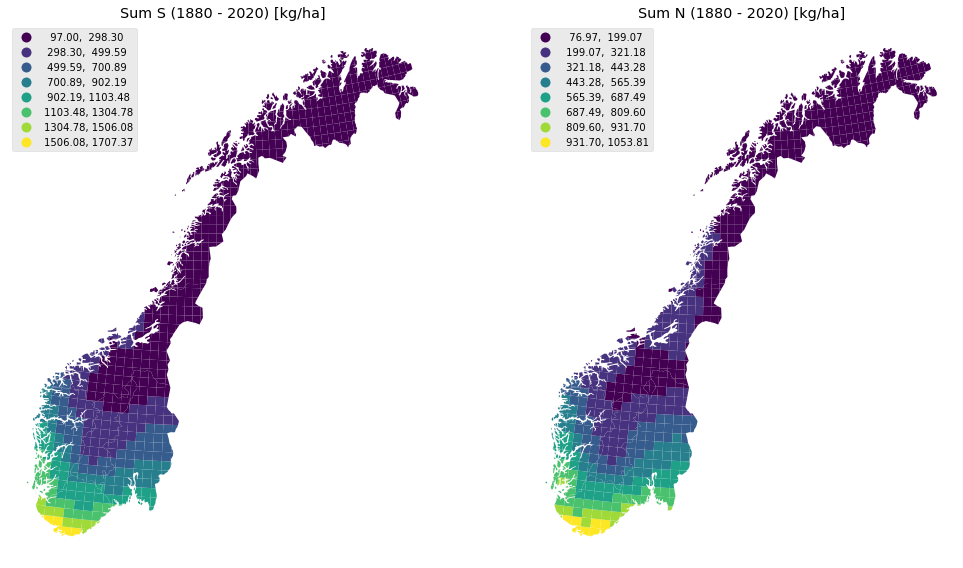

In [8]:
# Join dep data to spatial grid
s_gdf_wgs84 = gdf.merge(s_df, on="cell_id").copy()
n_gdf_wgs84 = gdf.merge(n_df, on="cell_id").copy()

# Clip to Norway for plotting
s_gdf_utm = s_gdf_wgs84.to_crs("epsg:32633").overlay(agg_gdf, how="intersection")
n_gdf_utm = n_gdf_wgs84.to_crs("epsg:32633").overlay(agg_gdf, how="intersection")

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
s_gdf_utm.plot(
    ax=axes[0],
    column="sum_interp_1880-2020_kg/ha",
    legend=True,
    scheme="equal_interval",
    k=8,
    legend_kwds={"loc": "upper left"},
)
n_gdf_utm.plot(
    ax=axes[1],
    column="sum_interp_1880-2020_kg/ha",
    legend=True,
    scheme="equal_interval",
    k=8,
    legend_kwds={"loc": "upper left"},
)
axes[0].set_title("Sum S (1880 - 2020) [kg/ha]")
axes[1].set_title("Sum N (1880 - 2020) [kg/ha]")
axes[0].set_axis_off()
axes[1].set_axis_off()
plt.tight_layout()

## 4. Summarise by regions

In [9]:
dep_dict = {
    "n": n_gdf_wgs84,
    "s": s_gdf_wgs84,
}

reg_dict = {
    "for": for_gdf,
    "agg": agg_gdf,
}

df_list = []
for par, dep_df in dep_dict.items():
    for reg, reg_gdf in reg_dict.items():
        # Reproject all data to CEA
        dep_gdf_cea = dep_df.to_crs({"proj": "cea"})
        reg_df_cea = reg_gdf.to_crs({"proj": "cea"})

        # Intersect
        dep_gdf_cea = dep_gdf_cea.overlay(reg_df_cea, how="intersection")

        # Get polygon areas
        dep_gdf_cea["area_ha"] = dep_gdf_cea["geometry"].area / (100 * 100)

        for st_yr in periods:
            # Total dep per polygon
            dep_gdf_cea[f"sum_interp_{st_yr}-2020_kg"] = (
                dep_gdf_cea[f"sum_interp_{st_yr}-2020_kg/ha"] * dep_gdf_cea["area_ha"]
            )

        # Totals for each region
        dep_gdf_cea = dep_gdf_cea.groupby("name").sum()

        for st_yr in periods:
            # Mean rates per region
            dep_gdf_cea[f"sum_interp_{st_yr}-2020_kg/ha"] = (
                dep_gdf_cea[f"sum_interp_{st_yr}-2020_kg"] / dep_gdf_cea["area_ha"]
            )

        # Add par name and region
        dep_gdf_cea["parameter"] = par.upper()
        if reg == "for":
            reg_name = "Forsuringsregionene"
        else:
            reg_name = "Heleen_aggregated"
        dep_gdf_cea["region_dataset"] = reg_name

        cols = [f"sum_interp_{st_yr}-2020_kg/ha" for st_yr in periods]
        dep_gdf_cea = dep_gdf_cea.reset_index()[
            [
                "parameter",
                "region_dataset",
                "name",
            ]
            + cols
        ]
        dep_gdf_cea.rename({"name": "region_name"}, inplace=True, axis="columns")

        df_list.append(dep_gdf_cea)

res_df = pd.concat(df_list, axis="rows")

out_csv = r"../output/accum_n_s_dep_by region.csv"
res_df.to_csv(out_csv, index=False)
res_df.head()

,parameter,region_dataset,region_name,sum_interp_1880-2020_kg/ha,sum_interp_1900-2020_kg/ha,sum_interp_1950-2020_kg/ha,sum_interp_1970-2020_kg/ha,sum_interp_1980-2020_kg/ha,sum_interp_1990-2020_kg/ha,sum_interp_2000-2020_kg/ha
0,N,Forsuringsregionene,Fjellregion - Sør-Norge,316.584610,286.462669,181.758181,125.747065,90.050549,53.750521,32.614813
1,N,Forsuringsregionene,Midt - Norge,207.898760,186.839259,121.103949,88.464769,68.578323,47.316041,29.312404
2,N,Forsuringsregionene,Nord - Norge,120.297762,108.609018,71.344962,52.455460,40.570468,28.413435,17.483948
3,N,Forsuringsregionene,Sørlandet - Vest,821.783276,765.056210,541.038802,405.690074,314.988936,212.456264,126.073369
4,N,Forsuringsregionene,Sørlandet - Øst,754.782468,698.885267,481.194772,351.652356,265.068340,168.884304,99.320027
